In [1]:
import time

import numpy as np
import torch

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('helpers/mplstyle.mplstyle')

In [2]:
from helpers.vulcano_data_helpers import (
    get_vulcanoe_data,
    fetch_topography_data,
    construct_highly_opinionated_prior
    )

from helpers.plotting_helpers import (
    plot_topography,
    # plot_slice_N,
    # plot_slice_E,
    # plot_marginal_Z,
    plot_prior_model,
    plot_posterior_model,
    plot_design_space_dict,
    plot_design
    )

In [3]:
Nx = 500
Ny = 500

x = np.linspace(-10, 10, Nx)
y = np.linspace(-10, 10, Ny)
z = 0

source_locations = np.meshgrid(
    x, y, indexing='ij')
source_locations = np.stack(source_locations, axis=-1)
source_locations = source_locations.reshape(-1, 2)

source_locations = np.hstack((source_locations, z * np.ones((source_locations.shape[0], 1))))

In [4]:
from helpers.vulcano_data_helpers import get_elevation

def correct_elevation(design, surface_data):
    for desc, loc in design:
                
        elevation = get_elevation(
            np.array(loc)*1e-3, surface_data)
        loc[2] = elevation
        
    return design

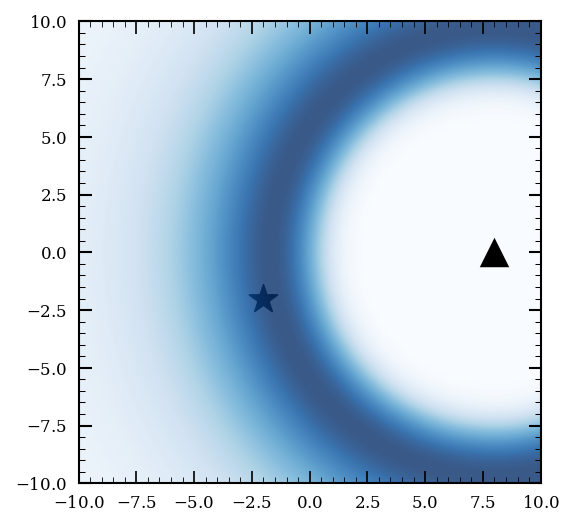

In [5]:
%matplotlib inline
from torch.distributions import Normal, Independent
from helpers.posterior_helpers import calculate_posterior, get_posterior_statisics

from helpers.forward_function_helpers import Forward_Function

baz_std = 10.0

forward_function = Forward_Function(
    vp             = 3.500,
    Q              = 15,
    f              = 2.0,
    ps_ratio       = 1/np.sqrt(3),
    tt_std_obs     = 0.01, 
    tt_std_vel     = 0.2,
    asl_std_Q      = 5.0,
    
    baz_std        = baz_std, 
    inc_std        = 20.0,
    
    array_baz_only            = False,
    correct_array_orientation = True,
    )


design = (
    (('asl',), np.array([ 8.0, 0.0, 0.0, 0.0, 0.0, 1.0])),
    # (('array',), np.array([ 0.0, 5.0, 0.0, 0.0, 0.0, 1.0])),
    )

test_model = np.array([-2.0, -2.0, 0.0])    
tt_obs, tt_obs_cov = forward_function(design, test_model[None])
tt, cov = forward_function(design, source_locations)

data_likelihood = Independent(
    Normal(
        torch.tensor(tt, dtype=torch.float32),
        torch.tensor(np.sqrt(cov), dtype=torch.float32)
    ), 1)

data_likelihood = data_likelihood.log_prob(
    torch.tensor(tt_obs, dtype=torch.float32)
).numpy()#.mean(axis=0)

data_likelihood = np.exp(data_likelihood.reshape((Nx, Ny)))

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

for desc, loc in design:
    if desc[0] in ['asl', 'tt']:
        ax.scatter(loc[0], loc[1], marker='^', color='black', s=200, linewidth=0)
    elif desc[0] == 'array':
        ax.scatter(loc[0], loc[1], marker='x', color='black', s=100, linewidths=2)

ax.scatter(test_model[0], test_model[1], marker='*', color='black', s=200, zorder=-10)

ax.imshow(
    data_likelihood.T,
    cmap='Blues', alpha=0.8,
    origin='lower', extent=[x.min(), x.max(), y.min(), y.max()],)

# # plot two lines with angle baz_std/2
# ax.plot(
#     [0, 20 * np.sin(np.deg2rad(baz_std/2))],
#     [0, 20 * np.cos(np.deg2rad(baz_std/2))],
#     color='black', linestyle='--', linewidth=1)

# ax.plot(
#     [0, 20 * np.sin(np.deg2rad(-baz_std/2))],
#     [0, 20 * np.cos(np.deg2rad(-baz_std/2))],
#     color='black', linestyle='--', linewidth=1)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

plt.show()

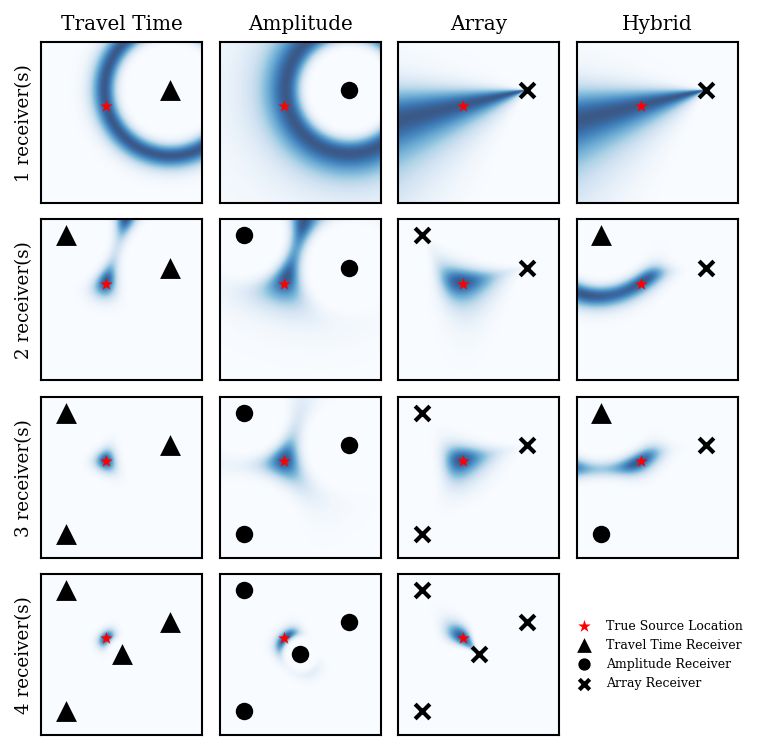

In [6]:

data_type_list = ['tt', 'asl', 'array']

test_model = np.array([-2.0, 2.0, 0.0])    

design_points = np.array([
    [   6.0,  4.0, 0.0, 0.0, 0.0, 1.0],
    [  -7.0,  8.0, 0.0, 0.0, 0.0, 1.0],
    [  -7.0, -7.0, 0.0, 0.0, 0.0, 1.0],
    [  -0.0, -0.0, 0.0, 0.0, 0.0, 1.0],
    ])

n_rec_list = range(1, len(design_points)+1)

fig, ax_dict = plt.subplot_mosaic(
    [[f'{data_type}_{i}' for data_type in data_type_list] + [f'combined_{i}'] for i in n_rec_list],
    figsize= (2*len(data_type_list), 1.5*len(n_rec_list)),
    gridspec_kw={'wspace': 0.1, 'hspace': 0.1}
)
fig.set_facecolor('white')

for data_type in data_type_list:

    ax_dict[f'{data_type}_1'].set_title(
    {
        'tt': 'Travel Time',
        'asl': 'Amplitude',
        'array': 'Array'
    }[data_type]
    )
    
    for n_rec in n_rec_list:
        ax = ax_dict[f'{data_type}_{n_rec}']

        if data_type == data_type_list[0]:
            ax.set_ylabel(f'{n_rec} receiver(s)')
        
        design =tuple(
            ((data_type,), design_points[i]) for i in range(n_rec)
            )
        
        tt_obs, tt_obs_cov = forward_function(design, test_model[None])
        tt, cov = forward_function(design, source_locations)

        data_likelihood = Independent(
            Normal(
                torch.tensor(tt, dtype=torch.float32),
                torch.tensor(np.sqrt(cov), dtype=torch.float32)
            ), 1)

        data_likelihood = data_likelihood.log_prob(
            torch.tensor(tt_obs, dtype=torch.float32)
        ).numpy()#.mean(axis=0)

        data_likelihood = np.exp(data_likelihood.reshape((Nx, Ny)))
        
        ax.imshow(
            data_likelihood.T,
            cmap='Blues', alpha=0.8,
            origin='lower', extent=[x.min(), x.max(), y.min(), y.max()],)

        for desc, loc in design:            
            if desc[0] == 'tt':
                ax.scatter(loc[0], loc[1], marker='^', color='black', s=100, linewidth=0)
            elif desc[0] == 'asl':
                ax.scatter(loc[0], loc[1], marker='o', color='black', s=70, linewidths=0)
            elif desc[0] == 'array':
                ax.scatter(loc[0], loc[1], marker='x', color='black', s=50, linewidths=2)

        ax.scatter(test_model[0], test_model[1], marker='*', color='red', s=40, zorder=10, linewidths=0)

        ax.set_xlim(-10, 10)
        ax.set_ylim(-10, 10)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
combined_design = (
    (('array',), design_points[0]),
    (('tt',), design_points[1]),
    (('asl',), design_points[2]),
    )
        
for n_rec in n_rec_list[:3]:
    ax = ax_dict[f'combined_{n_rec}']
    
    if n_rec == 1:
        ax.set_title('Hybrid')
        
    design = combined_design[:n_rec]
        
    tt_obs, tt_obs_cov = forward_function(design, test_model[None])
    tt, cov = forward_function(design, source_locations)
    
    data_likelihood = Independent(
        Normal(
            torch.tensor(tt, dtype=torch.float32),
            torch.tensor(np.sqrt(cov), dtype=torch.float32)
        ), 1)
    
    data_likelihood = data_likelihood.log_prob(
        torch.tensor(tt_obs, dtype=torch.float32)
    ).numpy()#.mean(axis=0)
    
    data_likelihood = np.exp(data_likelihood.reshape((Nx, Ny)))
    
    ax.imshow(
        data_likelihood.T,
        cmap='Blues', alpha=0.8,
        origin='lower', extent=[x.min(), x.max(), y.min(), y.max()],)
    
    for desc, loc in design:
        if desc[0] == 'tt':
            ax.scatter(loc[0], loc[1], marker='^', color='black', s=100, linewidth=0)
        elif desc[0] == 'asl':
            ax.scatter(loc[0], loc[1], marker='o', color='black', s=70, linewidths=0)
        elif desc[0] == 'array':
            ax.scatter(loc[0], loc[1], marker='x', color='black', s=50, linewidths=2)
            
    ax.scatter(test_model[0], test_model[1], marker='*', color='red', s=40, zorder=10, linewidths=0)
    
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
ax = ax_dict[f'combined_{n_rec_list[-1]}']

ax.scatter(
    [], [], marker='*', color='red', s=40, zorder=10, linewidths=0,
    label='True Source Location')

ax.scatter(
    [], [], marker='^', color='black', s=50, linewidth=0,
    label='Travel Time Receiver')

ax.scatter(
    [], [], marker='o', color='black', s=35, linewidths=0,
    label='Amplitude Receiver')

ax.scatter(
    [], [], marker='x', color='black', s=25, linewidths=2,
    label='Array Receiver')

ax.legend(loc='center', fontsize=6, frameon=False)

ax.set_xticks([])
ax.set_yticks([])

for side in ['top', 'right', 'bottom', 'left']:
    ax.spines[side].set_visible(False)
        
plt.show()